Using a 1-10 star scale, IMDb ranks TV series' by user ratings on a given series' home page. Gauging show performance off of users' singular rating seems overly broad and could be improved by taking the average rating across every episode. With Python's BeautifulSoup package, we can grab every episode rating for each show and rank them by series and season. The end result should provide a more accurate picture of how shows perform. To avoid web scraping across every TV series that exists, we'll maintain a minimum threshold of popularity, only grabbing shows with at least one episode with 10,000+ ratings.  

In [1]:
import requests
from bs4 import BeautifulSoup as bs

import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

class font:
   BOLD = '\033[1m'
   END = '\033[0m'

page_code = list(range(1,501,50))
page_link = ['https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=10000,&sort=user_rating,desc&start=' + str(x) + '&ref_=adv_nxt' for x in page_code]
soup_objects = [bs(requests.get(i).content) for i in page_link]
series_tags = [i.find_all(attrs = {'class': 'lister-item-header'}) for i in soup_objects]

def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

unpacked_series_tags = flatten(series_tags)

series_codes = list(set([i.find('a')['href'][7:-1] for i in unpacked_series_tags]))
series_page = ['https://www.imdb.com/title/' + str(i) for i in series_codes]


print(font.BOLD + 'Number of Qualifying Series: ' + str(len(series_page)))
print('\nChecking First 5 Elements in List: ' + font.END)
series_page[0:5]


Number of Qualifying Series: 49

Checking First 5 Elements in List: 


['https://www.imdb.com/title/tt2356777',
 'https://www.imdb.com/title/tt1758429',
 'https://www.imdb.com/title/tt2861424',
 'https://www.imdb.com/title/tt5180504',
 'https://www.imdb.com/title/tt0297626']

In [2]:
pd.set_option('display.max_rows', 10)

season_num = []
series_name = []

for i in series_page:
    temp_site = bs(requests.get(i).content, 'html.parser')
    series_name.append(temp_site.find(attrs = {'data-testid':'hero-title-block__title'}).text)
    try:
        if temp_site.find(attrs = {'id':'browse-episodes-season'})['aria-label'][1] == ' ':
            season_num.append(temp_site.find(attrs = {'id':'browse-episodes-season'})['aria-label'][0])
        else:
            season_num.append(temp_site.find(attrs = {'id':'browse-episodes-season'})['aria-label'][0:2])
    except:
        season_num.append('1')

temp_dict_1 = {'Series_Name': series_name, 'Series_Page': series_page, 'Season_Num': season_num}
temp_df = pd.DataFrame(temp_dict_1)

index_names = []
for i in ['Screen Two','American Masters','Ashish Chanchlani Vines']:
    index_names.append(temp_df[temp_df['Series_Name'] == i ].index[0])

temp_df.drop(index_names, inplace = True)

print(font.BOLD + 'Season_Num DataFrame:\n' + font.END + '("Series_Page" and "Season_Num" columns will be used to generate the URL for each season webpage)')
temp_df


Season_Num DataFrame:
("Series_Page" and "Season_Num" columns will be used to generate the URL for each season webpage)


,Series_Name,Series_Page,Season_Num
0,True Detective,https://www.imdb.com/title/tt2356777,3
1,Spartacus: Gods of the Arena,https://www.imdb.com/title/tt1758429,1
2,Rick and Morty,https://www.imdb.com/title/tt2861424,5
3,The Witcher,https://www.imdb.com/title/tt5180504,2
5,Vikings,https://www.imdb.com/title/tt2306299,6
...,...,...,...
44,Breaking Bad,https://www.imdb.com/title/tt0903747,5
45,Attack on Titan,https://www.imdb.com/title/tt2560140,4
46,Better Call Saul,https://www.imdb.com/title/tt3032476,6
47,Stranger Things,https://www.imdb.com/title/tt4574334,4


In [3]:
season_list = []
series_name_2 = []

for i,v in temp_df.iterrows(): 
    for x in range(1, int(v['Season_Num']) + 1):
        series_name_2.append(v['Series_Name'])
        season_list.append(v['Series_Page'] + '/episodes?season=' + str(x))

temp_dict_2 = {'Series_Name': series_name_2, 'Season_Page': season_list}
temp_df = pd.DataFrame(temp_dict_2)

temp_dict = {}

for i in season_list:
    
    temp = bs(requests.get(i).content)
    
    if '#' in temp.find('a', attrs = {'itemprop':'name'}).text and 'Know what this is about?' in temp.find('div', attrs = {'itemprop':'description'}).text:
        continue
   
    episode_title = [i.text for i in temp.find_all('a', attrs = {'itemprop':'name'})]
    episode_rating = [i.text for i in temp.find_all('span', attrs = {'class':'ipl-rating-star__rating'}) if '.' in i.text]
    episode_number = [i.text.strip() for i in temp.find_all('div', attrs = {'class':'hover-over-image zero-z-index'})]
    series_name = [temp.h3.a.text for i in episode_title]
    temp_list = [episode_title, episode_rating, episode_number, series_name]
        
    min = 100000
    for i in temp_list:
        if len(i) < min:
            min = len(i)
    episode_title = episode_title[:min]
    episode_rating = episode_rating[:min]
    episode_number = episode_number[:min]
    series_name = series_name[:min]
        
    if temp_dict == {}:
        temp_dict = {'Episode_Title': episode_title, 'Episode_Rating': episode_rating, 'Episode_Number':episode_number,
                    'Series_Name': series_name}
    else:
        temp_dict['Episode_Title'] += episode_title
        temp_dict['Episode_Rating'] += episode_rating
        temp_dict['Episode_Number'] += episode_number
        temp_dict['Series_Name'] += series_name

working_df = pd.DataFrame(temp_dict) 

episodes = working_df['Episode_Number']
season_number = []

for i in episodes:
  test = i.split(',')
  season_number.append(test[0].strip())

working_df['Season_Episode'] = working_df['Episode_Number']
working_df['Season_Number'] = season_number
working_df.drop('Episode_Number', axis = 1, inplace = True)


column_names = ['Episode_Title','Season_Episode','Season_Number','Episode_Rating','Series_Name']
working_df = working_df.reindex(columns = column_names)
working_df['Episode_Rating'] = working_df['Episode_Rating'].astype(float)

print(font.BOLD + 'Full Episode List')
working_df

Full Episode List


,Episode_Title,Season_Episode,Season_Number,Episode_Rating,Series_Name
0,The Long Bright Dark,"S1, Ep1",S1,9.0,True Detective
1,Seeing Things,"S1, Ep2",S1,8.9,True Detective
2,The Locked Room,"S1, Ep3",S1,9.2,True Detective
3,Who Goes There,"S1, Ep4",S1,9.7,True Detective
4,The Secret Fate of All Life,"S1, Ep5",S1,9.6,True Detective
...,...,...,...,...,...
2981,Stairmageddon,"S9, Ep19",S9,8.0,The Office
2982,Paper Airplane,"S9, Ep20",S9,8.0,The Office
2983,Livin' the Dream,"S9, Ep21",S9,9.1,The Office
2984,A.A.R.M.,"S9, Ep22",S9,9.5,The Office


In [4]:
s2 = working_df.loc[working_df['Season_Number'] == 'S2']
s2_titles = list(set(s2['Series_Name']))
s1 = working_df.loc[working_df['Series_Name'].isin(s2_titles) == False]
s1_titles = list(set(s1['Series_Name']))
long_series = working_df.loc[working_df['Series_Name'].isin(s2_titles)]
short_series = working_df.loc[working_df['Series_Name'].isin(s1_titles)]

from IPython.display import display, HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

pd.set_option('display.max_rows', 20)

series_test = long_series.groupby(['Series_Name'])
display(series_test.agg(Rating_by_Series=('Episode_Rating', 'mean')).round(2).sort_values(by = 'Rating_by_Series', ascending = False)[0:11])

season_test = long_series.groupby(['Series_Name','Season_Number'])
display(season_test.agg(Rating_by_Season=('Episode_Rating', 'mean')).round(2).sort_values(by = 'Rating_by_Season', ascending = False)[0:13])

short_test = short_series.groupby(['Series_Name'])
display(short_test.agg(Rating_by_Short_Series=('Episode_Rating', 'mean')).round(2).sort_values(by = 'Rating_by_Short_Series', ascending = False)[0:9])



,Rating_by_Series
Series_Name,
Attack on Titan,9.32
Dark,9.08
Breaking Bad,9.03
Person of Interest,9.01
Mr. Robot,9.01
Daredevil,8.98
Better Call Saul,8.86
Hannibal,8.84
Game of Thrones,8.83


Rating_by_Season
Series_Name        Season_Number                  
Attack on Titan    S3                         9.51
                   S4                         9.48
Breaking Bad       S5                         9.43
Attack on Titan    S2                         9.33
Mr. Robot          S4                         9.32
Game of Thrones    S4                         9.31
True Detective     S1                         9.31
Dark               S2                         9.29
Person of Interest S5                         9.28
Lucifer            S4                         9.26
Dark               S3                         9.24
Sherlock           S2                         9.20
Better Call Saul   S5                         9.18

,Rating_by_Short_Series
Series_Name,
Chernobyl,9.60
Loki,8.77
The Haunting of Hill House,8.69
The Queen's Gambit,8.63
Spartacus: Gods of the Arena,8.53
The Witcher,8.46
WandaVision,8.44
Squid Game,8.20
The Falcon and the Winter Soldier,8.03


[Text(0.5, 1.0, 'Average Rating by Season (All Shows)'), Text(0.5, 0, 'Season Number'), Text(0, 0.5, 'Average Rating'), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4'), Text(4, 0, '5'), Text(5, 0, '6'), Text(6, 0, '7'), Text(7, 0, '8')], (7.7, 8.6)]


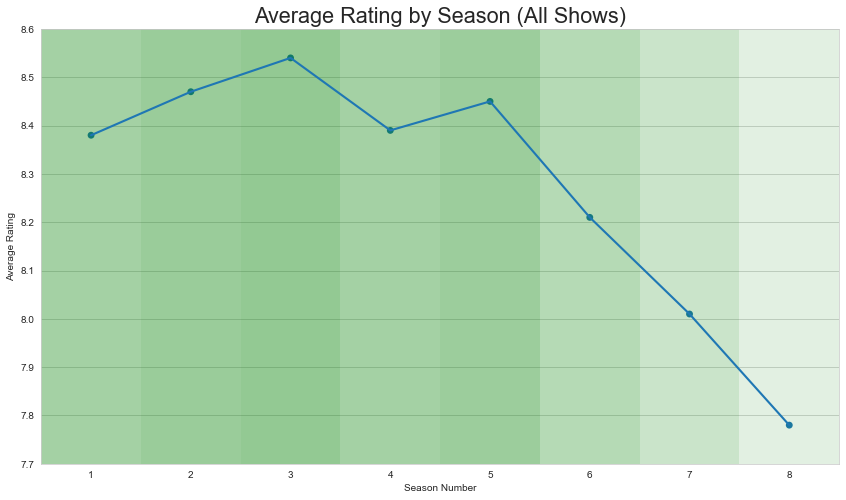

In [5]:
testing = long_series.groupby(['Season_Number'])
season_df = testing['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number').reset_index()
season_df['Season_Num'] = [int(v['Season_Number'][1:]) for i,v in season_df.iterrows()]
season_df.drop('Season_Number', axis = 1, inplace = True)
season_df = season_df.reindex(columns = ['Season_Num','mean']).sort_values('Season_Num').reset_index(drop = True)[0:8]

sb.set_style("whitegrid")
plt.figure(figsize = (14.3,8))

plt.axvspan(-.5, .5, color='green', alpha=37.5, lw=0)
plt.axvspan(.5, 1.5, color='green', alpha=27.5, lw=0)
plt.axvspan(1.5, 2.5, color='green', alpha=20.5, lw=0)
plt.axvspan(2.5, 3.5, color='green', alpha=37.5, lw=0)
plt.axvspan(3.5, 4.5, color='green', alpha=29.5, lw=0)
plt.axvspan(4.5, 5.5, color='green', alpha=54.5, lw=0)
plt.axvspan(5.5, 6.5, color='green', alpha=75.5, lw=0)
plt.axvspan(6.5, 7.5, color='green', alpha=99.5, lw=0)

g = sb.pointplot(data = season_df, x = season_df['Season_Num'], y = season_df['mean'], scale = .78)
plt.rcParams.update({'font.size': 18})
print(g.set(title = 'Average Rating by Season (All Shows)', xlabel = 'Season Number', ylabel = 'Average Rating', xticklabels = [1,2,3,4,5,6,7,8], ylim=(7.7,8.6)))
